In [16]:
import jieba
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

In [20]:
class DbscanClustering():
    def __init__(self, stopwords_path=None):
        self.stopwords = self.load_stopwords(stopwords_path)
        self.vectorizer = CountVectorizer()
        self.transformer = TfidfTransformer()
        self.result = {}
        self.corpus_path = ""

    def load_stopwords(self, stopwords=None):
        """
        加载停用词
        :param stopwords:
        :return:
        """
        if stopwords:
            with open(stopwords, 'r', encoding='utf-8') as f:
                return [line.strip() for line in f]
        else:
            return []

    def preprocess_data(self, corpus_path):
        """
        文本预处理，每行一个文本
        :param corpus_path:
        :return:
        """
        self.corpus_path = corpus_path
        corpus = []
        with open(corpus_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                line = re.sub(r"[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+", " ", line)
                corpus.append(' '.join([word for word in jieba.lcut(line) if word not in self.stopwords]))
        return corpus

    def get_text_tfidf_matrix(self, corpus):
        """
        获取tfidf矩阵
        :param corpus:
        :return:
        """
        tfidf = self.transformer.fit_transform(self.vectorizer.fit_transform(corpus))

        # 获取词袋中所有词语
        # words = self.vectorizer.get_feature_names()

        # 获取tfidf矩阵中权重
        weights = tfidf.toarray()
        return weights

    def pca(self, weights, n_components=2):
        """
        PCA对数据进行降维
        :param weights:
        :param n_components:
        :return:
        """
        pca = PCA(n_components=n_components)
        return pca.fit_transform(weights)
    
    def export_result(self):
        #输出结果
        with open(self.corpus_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for cluster, indexes in self.result.items():
                file = open('../data/clusters/' + str(cluster) + '.txt', 'w')
                for index in indexes:
                    file.write("document"+str(index)+": " + lines[index] + "\n")
                file.close()

    def dbscan(self, corpus_path, eps=0.1, min_samples=3, fig=True):
        """
        DBSCAN：基于密度的文本聚类算法
        :param corpus_path: 语料路径，每行一个文本
        :param eps: DBSCA中半径参数
        :param min_samples: DBSCAN中半径eps内最小样本数目
        :param fig: 是否对降维后的样本进行画图显示
        :return:
        """
        corpus = self.preprocess_data(corpus_path)
        weights = self.get_text_tfidf_matrix(corpus)

        pca_weights = self.pca(weights, 5)

        clf = DBSCAN(eps=eps, min_samples=min_samples)

        y = clf.fit_predict(pca_weights)

        if fig:
            plt.scatter(pca_weights[:, 0], pca_weights[:, 1], c=y)
            plt.show()

        # 中心点
        # centers = clf.cluster_centers_

        # 用来评估簇的个数是否合适,距离约小说明簇分得越好,选取临界点的簇的个数
        # score = clf.inertia_

        # 每个样本所属的簇
        for text_idx, label_idx in enumerate(y):
            if label_idx not in self.result:
                self.result[label_idx] = [text_idx]
            else:
                self.result[label_idx].append(text_idx)
        return self.result

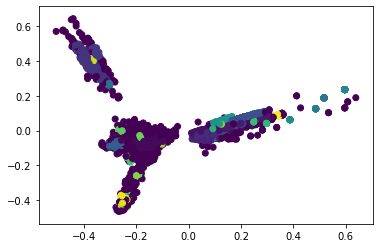

{0: [0, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 16, 17, 18, 20, 21, 24, 25, 28, 29, 31, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 64, 65, 70, 72, 73, 74, 76, 90, 92, 96, 100, 107, 121, 122, 135, 144, 146, 156, 161, 162, 177, 190, 191, 193, 209, 210, 216, 220, 226, 230, 233, 242, 247, 248, 254, 256, 276, 286, 287, 294, 296, 300, 308, 312, 319, 324, 336, 340, 341, 342, 343, 345, 384, 388, 393, 399, 417, 438, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 477, 478, 480, 481, 482, 483, 484, 485, 486, 488, 494, 496, 497, 499, 501, 512, 513, 514, 519, 520, 521, 524, 526, 532, 547, 551, 554, 555, 564, 571, 581, 586, 599, 602, 604, 614, 617, 625, 634, 638, 639, 646, 647, 648, 667, 682, 687, 694, 705, 707, 712, 723, 727, 728, 731, 741, 744, 755, 760, 763, 767, 774, 782, 783, 790, 799, 812, 839, 847, 851, 852, 861, 865, 866, 873, 876, 879, 886, 892, 893, 895, 920, 922, 932, 934, 935, 961, 976, 977, 979, 980, 993, 994, 995, 999, 1008, 1037, 1050, 1088,

In [24]:
if __name__ == '__main__':
    dbscan = DbscanClustering(stopwords_path='../data/stop_words.txt')
    result = dbscan.dbscan('../data/documents_股价上涨.txt', eps=0.02, min_samples=8)
    print(result)

In [26]:
dbscan.export_result()

In [27]:
len(result[-1])

1725

In [4]:
def showDoc(corpus_path, index):
    with open(corpus_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    for idx in result[index]:
        print("document"+str(idx)+": ", lines[idx])

In [13]:
showDoc('../data/documents_股价下跌.txt', 33)

document3382:  TechWeb 4月3日 昨日晚间瑞幸咖啡发布公告承认公司COO及其部分下属员工伪造交易相关销售额约22亿元 受此影响 瑞幸咖啡股价大跌75.57 今天 港股开盘 神州租车股价开盘大跌并一路下探 截至发稿已大跌超40 跌至2.53港元 公开资料显示 瑞幸咖啡大股东为陆正耀 持股23.94 神州租车大股东为陆正耀夫妇 持股29.76 而瑞幸咖啡造假中心人物 瑞幸咖啡COO刘剑在加盟之前 曾担任神州优车集团的收益管理主管 神州优车正是神州租车的实际控制人 此外 瑞幸咖啡的CEO钱治亚 CMO杨飞等都来自神州系 不管是股权上 还是管理团队方面 瑞幸咖啡和神州租车之间都有着千丝万缕联系 瑞幸咖啡的造假引发资本市场对其的信任破灭 开盘暴跌引发后多次熔断 股价一夜跌去75.57 神州租车受到拖累 股价跟着大跌也就不足为奇了

document3384:  咖啡是有很多人爱喝的了 不同品牌的咖啡是有很多的 其中这瑞幸咖啡的话应该不少人都有喝过吧 因为这瑞幸咖啡的火爆 大家也是会关注到这瑞幸咖啡的营收等问题的 近日就有消息称瑞幸咖啡伪造交易22亿了 那么这瑞幸咖啡的股价是多少呢 瑞幸咖啡最新消息 瑞幸咖啡总部位于厦门 由神州优车集团原COO钱治亚创建 是中国最大的连锁咖啡品牌 瑞幸咖啡通过充分利用移动互联网和大数据技术的新零售模式 与各领域顶级供应商深度合作 致力为客户提供高品质 高性价比 高便利性的产品 我们一起来看看 瑞幸咖啡股价 据最新的消息了解到 4月2日盘前 瑞幸咖啡内部调查显示 2019年二季度至四季度期间虚增了22亿人民币交易额 开盘前 公司股价就跌幅超过80 开盘后没几分钟 瑞幸咖啡股价就熔断了 较上市后高点50美元仅剩不到十分之一 公司市值缩水55亿美元 值得注意的是 瑞幸咖啡称 公司正在评估不当行为对其财务报表的整体财务影响 因此 投资者不应再相信公司以前的财务报表和截至9月30日的9个月的收益发布 2019年以及从2019年4月1日起至2019年9月30日止的两个季度 包括先前对2019年第四季度产品净收入的指导 以及与这些合并财务报表有关的其他信息 调查正在进行中 公司将继续评估其先前发布的财务状况和做出其他可能调整

document3413:  闻名遐迩的美股瑞幸咖啡又一次成为了焦点 算是牛逼了一把 据媒体报道 瑞幸公司向监